In [3]:
import atlite
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import time
from shapely.geometry import Point
import matplotlib.pyplot as plt
from enum import Enum

# Resources Paths
paths = {"era5_eu_2013": "resources/europe-2013-era5.nc",
         "era5_tutorial": "resources/europe-2013-era5-tutorial.nc",
         "offshore_shape": "resources/regions_offshore_elec_s_37.geojson",
         "onshore_shape": "resources/regions_onshore_elec_s_37.geojson",
         "capfacs": "resources/capfacs_37.csv"}

In [4]:
era_data = xr.open_dataset(filename_or_obj=paths["era5_eu_2013"], engine="netcdf4")
era_data

<xarray.Dataset>
Dimensions:           (x: 157, y: 131, time: 8760)
Coordinates:
  * x                 (x) float64 -12.0 -11.7 -11.4 -11.1 ... 34.2 34.5 34.8
  * y                 (y) float64 33.0 33.3 33.6 33.9 ... 71.1 71.4 71.7 72.0
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
    lon               (x) float64 ...
    lat               (y) float64 ...
Data variables:
    height            (y, x) float32 ...
    wnd100m           (time, y, x) float32 ...
    roughness         (time, y, x) float32 ...
    influx_toa        (time, y, x) float32 ...
    influx_direct     (time, y, x) float32 ...
    influx_diffuse    (time, y, x) float32 ...
    albedo            (time, y, x) float32 ...
    temperature       (time, y, x) float32 ...
    soil temperature  (time, y, x) float32 ...
    runoff            (time, y, x) float32 ...
Attributes:
    module:             era5
    prepared_features:  ['runoff', 'height', 'wind', 'influx', 'temperature']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3

In [5]:
era_cutout = atlite.Cutout(paths["era5_eu_2013"])
era_cutout

<Cutout "europe-2013-era5">
 x = -12.00 ⟷ 34.80, dx = 0.30
 y = 33.00 ⟷ 72.00, dy = 0.30
 time = 2013-01-01 ⟷ 2013-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [6]:
era_cutout.available_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
Name: variables, dtype: object

In [9]:
era_cutout.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

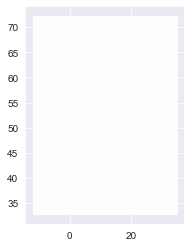

In [13]:
era_cutout.grid.plot()

### Wind
Generate wind generation time-series
Extrapolates 10m wind speed with monthly surface roughness to hub height and evaluates the power curve.

### PV
Convert downward-shortwave, upward-shortwave radiation flux and ambient temperature into a pv generation time-series

### Solar-Thermal
Convert downward short-wave radiation flux and outside temperature into time series for solar thermal collectors.
Mathematical model and defaults for c0, c1 based on model in [1].

In [42]:
gdf_onshore = gpd.read_file(paths["onshore_shape"])
gdf_offshore = gpd.read_file(paths["offshore_shape"])
gdf_offshore

,name,geometry
0,AL0 0,"POLYGON ((19.98542 39.69475, 20.01003 39.69120..."
1,BE0 0,"POLYGON ((3.25367 51.34858, 3.10403 51.31485, ..."
2,BG0 0,"POLYGON ((29.34583 42.24111, 28.32389 41.99778..."
3,DE0 0,"MULTIPOLYGON (((14.22389 53.70083, 13.95916 53..."
4,DK0 0,"POLYGON ((9.99277 55.70499, 10.04583 55.75027,..."
5,DK4 0,"MULTIPOLYGON (((12.93400 54.83381, 12.74997 54..."
6,EE6 0,"POLYGON ((23.72555 58.74471, 23.53527 58.74180..."
7,ES0 0,"MULTIPOLYGON (((-5.36028 35.91625, -5.39555 35..."
8,ES2 0,"POLYGON ((1.87083 37.64028, 1.73314 37.62605, ..."
9,FI4 0,"MULTIPOLYGON (((23.43159 59.95382, 23.56135 59..."


<AxesSubplot:>

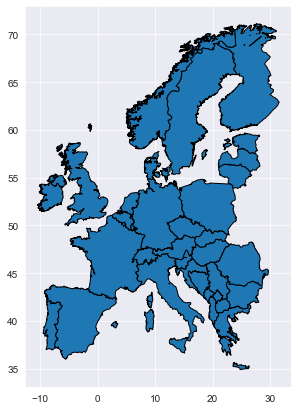

In [39]:
gdf_onshore.plot(figsize=(7, 7), edgecolor="black")

<AxesSubplot:>

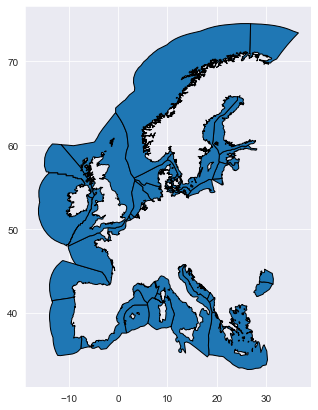

In [40]:
gdf_offshore.plot(figsize=(7, 7), edgecolor="black")